# Introduction to pybvh

In [1]:
import numpy as np
np.set_printoptions(precision=3)

import sys
sys.path.append('../')

import pybvh

from pathlib import Path

bvh_folder = Path('../bvh_data')

# Bvh object and basic utilities

## Reading and writing a bvh file

Arguably the most important function of the library is to be able to easily and speedily read and parse bvh files. This is achieved through the function `read_bvh_file`. It returns a `Bvh` object.

In [2]:
filepath = bvh_folder / 'bvh_test1.bvh'
bvh = pybvh.read_bvh_file(filepath)

type(bvh)

pybvh.bvh.Bvh

To save a bvh object to a bvh file, we can just as easily call the class method `to_bvh_file`.

In [3]:
new_filepath = bvh_folder / 'bvh_example.bvh'

bvh.to_bvh_file(new_filepath, verbose=False)

Since we didn't manipulate the `Bvh` object at all in this example, the read file and written file are completely similar

## Bvh object

By printint the `Bvh` object, we can quickly see the number of joints in the skeleton, the total number of frames and their framerates.

In [4]:
filepath = bvh_folder / 'bvh_test1.bvh'
bvh = pybvh.read_bvh_file(filepath)

print(bvh)

24 elements in the Hierarchy, 56 frames at a frequency of 0.033333Hz


The frequency is calculated as 1 / frames per second.

We can also access the frame frequency and the total frame counts directly using the respective properties `frame_frequency` and `frame_count`.

In [5]:
print(f"frame frequency:     {bvh.frame_frequency}")
print(f"total frame counts:  {bvh.frame_count}")

frame frequency:     0.03333333333333333
total frame counts:  56


From the Hierarchy in the bvh files, each joint is extracted and become its own object, that we call nodes objects.

# Nodes objects for the bvh hierarchy

To list a list of all the nodes, or joints, stored in the bvh object, we can call  the property `nodes`.

In [6]:
filepath = bvh_folder / 'bvh_test1.bvh'

bvh = pybvh.read_bvh_file(filepath)
bvh.nodes[0:9]

[BvhRoot(name = Hips, offset = [0. 0. 0.], pos_channels = ['X', 'Y', 'Z'], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Spine)', 'BvhJoint(JOINT RightUpLeg)', 'BvhJoint(JOINT LeftUpLeg)'], parent = None),
 BvhJoint(name = Spine, offset = [0.    0.    4.453], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Spine1)'], parent = ROOT Hips),
 BvhJoint(name = Spine1, offset = [ 0.    -0.773  4.385], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Spine2)'], parent = JOINT Spine),
 BvhJoint(name = Spine2, offset = [ 0.    -0.388  4.436], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Spine3)'], parent = JOINT Spine1),
 BvhJoint(name = Spine3, offset = [0.    0.    4.453], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Neck)', 'BvhJoint(JOINT RightShoulder)', 'BvhJoint(JOINT LeftShoulder)'], parent = JOINT Spine2),
 BvhJoint(name = Neck, offset = [0.    0.573 5.725], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Nec

Each element of this list is either
- a BvhRoot, only one, the root of the file; it is always the first element,
- a BvhJoint, for all the actual joint other than the root,
- a BvhNode, for the end point of some joints (the head in this example).

## BvhNode object

In [7]:
bvh.nodes[8]

BvhNode(name = End Site Head, offset = [0.    0.    3.549], parent = JOINT Head)

A BvhNode object has 3 properties;
- the `name` of the node,
- an `offset` list, used to calculate the length of the skeleton bones (always given as [x, y, z]),
- a `parent` pointer. 

This object is used for the End site of the bvh files, and you can see it appear here in the node's name.

The `parent` property points directly to the actual parent object, which allows chaining operation:

In [8]:
bvh.nodes[8].parent.name

'Head'

## BvhJoint object

In [9]:
bvh.nodes[2]

BvhJoint(name = Spine1, offset = [ 0.    -0.773  4.385], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Spine2)'], parent = JOINT Spine)

The BvhJoint object inherits from the BvhNode class. In addition to the `name`, `offset` and `parent` parameters, it also has the following properties:

- a `rot_channels` list, indicating the Euler angle rotation order for this joint,
- a `children` list.

The elements of the `children` list are pointers to nodes objects in the nodes list. Same as the parent, this allows acces to the object themselves.

In [10]:
node = bvh.nodes[2]
print(f'{node.children[0].name} is a children of {node.name}, with an offset of {node.children[0].offset}.')

Spine2 is a children of Spine1, with an offset of [ 0.    -0.388  4.436].


## BvhRoot object

The root node is alway the first in the `nodes` list. 

In [11]:
bvh.nodes[0]

BvhRoot(name = Hips, offset = [0. 0. 0.], pos_channels = ['X', 'Y', 'Z'], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Spine)', 'BvhJoint(JOINT RightUpLeg)', 'BvhJoint(JOINT LeftUpLeg)'], parent = None)

It can also be directly accessed through the bvh object `root` property.

In [12]:
bvh.root

BvhRoot(name = Hips, offset = [0. 0. 0.], pos_channels = ['X', 'Y', 'Z'], rot_channels = ['Z', 'Y', 'X'], children = ['BvhJoint(JOINT Spine)', 'BvhJoint(JOINT RightUpLeg)', 'BvhJoint(JOINT LeftUpLeg)'], parent = None)

The BvhRoot class inherits from the BvhJoint class. In addition to the previous properties, BvhRoot object also possesses a `pos_channels` property which tells us the order of the cartesian coordinate of the hips as they appear in the frames. 

# Angles Data

## Using directly the Numpy data

In the the `Bvh` object, motion data is stored in two structured arrays: `root_pos` (shape `(F, 3)`, with `F` the number of frames) for the root spatial coordinates, and `joint_angles` (shape `(F, J, 3)` with `J` the number of joints) for the Euler angle rotations of each joint.

In [13]:
filepath = bvh_folder / 'bvh_test1.bvh'
bvh = pybvh.read_bvh_file(filepath)

print(f"root_pos shape:       {bvh.root_pos.shape}")
print("Root positions (first 5 frames):")
print(bvh.root_pos[0:5])

print(f"\njoint_angles shape:   {bvh.joint_angles.shape}")
print("First joint angles (first 5 frames, joint 0 = Hips):")
print(bvh.joint_angles[0:5, 0])

root_pos shape:       (56, 3)
Root positions (first 5 frames):
[[ 9.527 -0.75  36.277]
 [ 9.481 -0.75  36.274]
 [ 9.431 -0.751 36.271]
 [ 9.382 -0.752 36.267]
 [ 9.327 -0.758 36.263]]

joint_angles shape:   (56, 24, 3)
First joint angles (first 5 frames, joint 0 = Hips):
[[88.235 -1.07   0.645]
 [88.237 -1.076  0.643]
 [88.235 -1.085  0.643]
 [88.215 -1.094  0.631]
 [88.202 -1.093  0.641]]


In this example, `root_pos` has 56 frames × 3 position channels. `joint_angles` has 56 frames × 24 joints × 3 Euler‑angle axes.

## Bvh to DataFrame

To make more sense of the data visually, we can also use DataFrames from the pandas library. The method `get_df_constructor()` provides an easy transcription into a pandas DataFrame. This conversion will also automatically add a time column at the front.

In [14]:
import pandas as pd

df = pd.DataFrame(bvh.get_df_constructor())
df.head()

,time,Hips_X_pos,Hips_Y_pos,Hips_Z_pos,Hips_Z_rot,Hips_Y_rot,Hips_X_rot,Spine_Z_rot,Spine_Y_rot,Spine_X_rot,...,LeftUpLeg_X_rot,LeftLeg_Z_rot,LeftLeg_Y_rot,LeftLeg_X_rot,LeftFoot_Z_rot,LeftFoot_Y_rot,LeftFoot_X_rot,LeftToeBase_Z_rot,LeftToeBase_Y_rot,LeftToeBase_X_rot
0,0.000000,9.5267,-0.7495,36.2768,88.2354,-1.0699,0.6448,1.0586,-0.3574,-0.4139,...,-3.3171,0.0,0.0,-5.0531,12.3552,0.5089,4.1906,-0.0,0.0,-6.8240
1,0.033333,9.4809,-0.7505,36.2740,88.2366,-1.0764,0.6430,1.0583,-0.3432,-0.3856,...,-3.3874,-0.0,0.0,-5.0663,12.3168,0.4888,4.2627,-0.0,0.0,-6.8279
2,0.066667,9.4309,-0.7515,36.2709,88.2352,-1.0846,0.6434,1.0640,-0.3296,-0.3463,...,-3.4692,0.0,0.0,-5.0733,12.2865,0.4516,4.3450,0.0,-0.0,-6.8369
3,0.100000,9.3817,-0.7516,36.2674,88.2153,-1.0943,0.6312,1.0731,-0.3158,-0.3087,...,-3.5158,0.0,-0.0,-5.1259,12.2568,0.4194,4.4312,-0.0,-0.0,-6.8314
4,0.133333,9.3269,-0.7580,36.2634,88.2022,-1.0925,0.6415,1.0803,-0.2905,-0.2725,...,-3.6291,0.0,0.0,-5.1154,12.2377,0.3811,4.5075,-0.0,0.0,-6.8667


We can then work on the data as we normally would with a DataFrame.

In [15]:
df['Hips_X_pos'] = 0*df['Hips_X_pos']
df.head()

,time,Hips_X_pos,Hips_Y_pos,Hips_Z_pos,Hips_Z_rot,Hips_Y_rot,Hips_X_rot,Spine_Z_rot,Spine_Y_rot,Spine_X_rot,...,LeftUpLeg_X_rot,LeftLeg_Z_rot,LeftLeg_Y_rot,LeftLeg_X_rot,LeftFoot_Z_rot,LeftFoot_Y_rot,LeftFoot_X_rot,LeftToeBase_Z_rot,LeftToeBase_Y_rot,LeftToeBase_X_rot
0,0.000000,0.0,-0.7495,36.2768,88.2354,-1.0699,0.6448,1.0586,-0.3574,-0.4139,...,-3.3171,0.0,0.0,-5.0531,12.3552,0.5089,4.1906,-0.0,0.0,-6.8240
1,0.033333,0.0,-0.7505,36.2740,88.2366,-1.0764,0.6430,1.0583,-0.3432,-0.3856,...,-3.3874,-0.0,0.0,-5.0663,12.3168,0.4888,4.2627,-0.0,0.0,-6.8279
2,0.066667,0.0,-0.7515,36.2709,88.2352,-1.0846,0.6434,1.0640,-0.3296,-0.3463,...,-3.4692,0.0,0.0,-5.0733,12.2865,0.4516,4.3450,0.0,-0.0,-6.8369
3,0.100000,0.0,-0.7516,36.2674,88.2153,-1.0943,0.6312,1.0731,-0.3158,-0.3087,...,-3.5158,0.0,-0.0,-5.1259,12.2568,0.4194,4.4312,-0.0,-0.0,-6.8314
4,0.133333,0.0,-0.7580,36.2634,88.2022,-1.0925,0.6415,1.0803,-0.2905,-0.2725,...,-3.6291,0.0,0.0,-5.1154,12.2377,0.3811,4.5075,-0.0,0.0,-6.8667


## DataFrame to Bvh

We can also do the opposite, and transform a DataFrame into a Bvh. However, since the Hierarchy information (how the joints relate to each other) is not present in the DataFrame, we need another piece of information to complete it. There are two ways to create the Hierarchy information.

The first possibility is to have a list of Bvh nodes objects. We then call the df_to_bvh function to operate the magic. This function also do a deep copy of the hierarchy, so that the parent and child parameters points to the new objects and not the copied ones.

In [16]:
hierarchy_list = bvh.nodes
new_bvh_object = pybvh.df_to_bvh(hierarchy_list, df)
new_bvh_object

Bvh(nodes=[ROOT Hips, Spine, Spine1, Spine2, Spine3, Neck, Neck1, Head, RightShoulder, RightArm, RightForeArm, RightHand, LeftShoulder, LeftArm, LeftForeArm, LeftHand, RightUpLeg, RightLeg, RightFoot, RightToeBase, LeftUpLeg, LeftLeg, LeftFoot, LeftToeBase], frames=array(root_pos=(56, 3), joint_angles=(56, 24, 3), dtype=float64), frame_frequency=0.033333)

In [17]:
print("Root positions (first 5 frames) — (notice the Hips_X that was zeroed previously):")
print(new_bvh_object.root_pos[0:5])
print("\nFirst joint angles (first 5 frames, joint 0 = Hips):")
print(new_bvh_object.joint_angles[0:5, 0])

Root positions (first 5 frames) — (notice the Hips_X that was zeroed previously):
[[ 0.    -0.75  36.277]
 [ 0.    -0.75  36.274]
 [ 0.    -0.751 36.271]
 [ 0.    -0.752 36.267]
 [ 0.    -0.758 36.263]]

First joint angles (first 5 frames, joint 0 = Hips):
[[88.235 -1.07   0.645]
 [88.237 -1.076  0.643]
 [88.235 -1.085  0.643]
 [88.215 -1.094  0.631]
 [88.202 -1.093  0.641]]


The other possibility to transfer the Hierarchy information is through a dictionnary of the following format:

We can write this dictionnary manually. The dictionnary is not assumed to be ordered so the position of the name of joint in the dictionnary is not taken into consideration. We can also obtain such a dictionnary through the Bvh object:

In [18]:
hier_info_dict = bvh.hierarchy_info_as_dict()
print(f'The dictionnary keys:\n{hier_info_dict.keys()}')
print(f"\nExample of the content for the joint 'Hips':\n{hier_info_dict['Hips']}")

The dictionnary keys:
dict_keys(['Hips', 'Spine', 'Spine1', 'Spine2', 'Spine3', 'Neck', 'Neck1', 'Head', 'End Site Head', 'RightShoulder', 'RightArm', 'RightForeArm', 'RightHand', 'End Site RightHand', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand', 'End Site LeftHand', 'RightUpLeg', 'RightLeg', 'RightFoot', 'RightToeBase', 'End Site RightToeBase', 'LeftUpLeg', 'LeftLeg', 'LeftFoot', 'LeftToeBase', 'End Site LeftToeBase'])

Example of the content for the joint 'Hips':
{'offset': array([0., 0., 0.]), 'pos_channels': ['X', 'Y', 'Z'], 'rot_channels': ['Z', 'Y', 'X'], 'children': ['Spine', 'RightUpLeg', 'LeftUpLeg'], 'parent': None}


In [19]:
newer_bvh_object = pybvh.df_to_bvh(hier_info_dict, df)
newer_bvh_object

Bvh(nodes=[ROOT Hips, Spine, Spine1, Spine2, Spine3, Neck, Neck1, Head, RightShoulder, RightArm, RightForeArm, RightHand, LeftShoulder, LeftArm, LeftForeArm, LeftHand, RightUpLeg, RightLeg, RightFoot, RightToeBase, LeftUpLeg, LeftLeg, LeftFoot, LeftToeBase], frames=array(root_pos=(56, 3), joint_angles=(56, 24, 3), dtype=float64), frame_frequency=0.033333)

# Bvh Visualisation    

## Plotting a frame

Finally, it would be nice to be able to visualize the skeleton posture expressed in the bvh file. To do that, easy plotting functions are included in `pybvh.plot`. This visualisation needs the third party library `matploltib` in order to function properly.

Let's visualize the skeleton we have been working with since the beginning. First, we will visualize the rest pose of the bvh file. The rest pose is the pose calibrated when all angles are 0; in other words, it is what the skeleton looks like when only taking the offset information of every joints. It is often a T-pose or an A-pose.

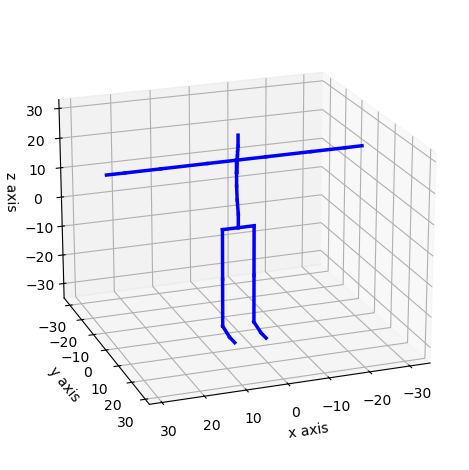

In [20]:
import matplotlib.pyplot as plt

#we need to first obtain the rest pose we want to plot
rest_pose = bvh.get_rest_pose()

fig, ax = pybvh.plot.plot_frame(bvh, rest_pose)
plt.show()

We can visualize another skeleton for comparison

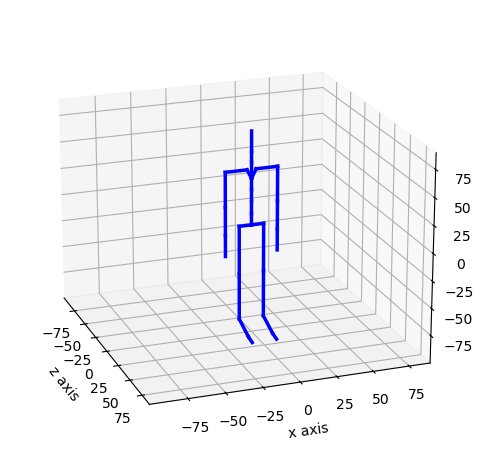

In [21]:
new_filepath = bvh_folder / 'bvh_test2.bvh'

new_bvh = pybvh.read_bvh_file(new_filepath)

rest_pose = new_bvh.get_rest_pose()

fig, ax = pybvh.plot.plot_frame(new_bvh, rest_pose)
plt.show()

It doesn't have to be a rest pose. Any frame can be visualized too, simply by passing the index number of the frames to the function `plot_frame`.

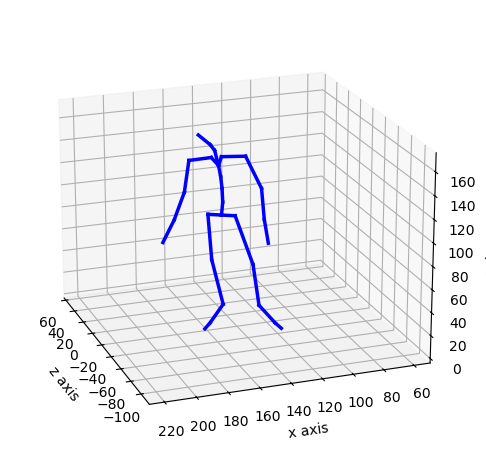

In [22]:
visualized_frame_index = 5

fig, ax = pybvh.plot.plot_frame(new_bvh, visualized_frame_index)
plt.show()

## Plotting the bvh animation

Finally, if we want to visualize the animation, we can do so using matplotlib too through the function `plot_animation` in `pybvh.plot`. It requires one necessary argument, the bvh object. The addition optional arguments are the followings:
- `centered`: direct how the animation is centered. Possibilities are
  - "world": no change to the root position, 
  - "first": the position of the root in the first frame of the animation is set at [0, 0, 0].
  - "skeleton": the position of the root in all thes frames of the animation is set at [0, 0, 0].
- `direction_ref`: choose how to determine the frontward direction. Possibilities are
  - "first": use the first frame to automatically determine the frontward direction of the plot. 
  - "rest": use the rest pose to automatically determine the frontward direction of the plot. 
- `show_axis`: boolean, equivalent to doing ax.axis(True/False)
- `savefile`: bool, decide to save the file or not
- `filepath`: only used if `savefile=True`, decided the path where to save the file.

In case of a jupyter notebook, there may be some trouble with showing the animation directly in the notebook. In this case, you can still save the animation (using the argument `savefile=True` and `filepath="..."`).

/Users/victor/projects/pybvh/tutorials/../pybvh/plot.py:192: UserWarning: FFmpeg not found! Cannot save as .mp4.
Falling back to PillowWriter and saving as '../bvh_animation.gif' instead.
.webp and .html are also available.
  warnings.warn(


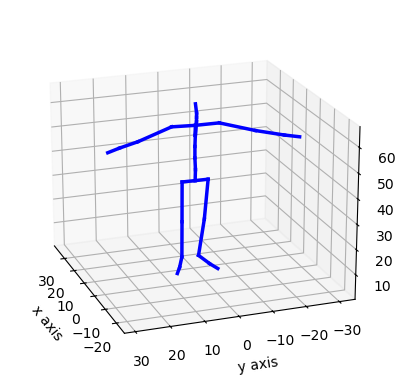

In [23]:
fig, ax = pybvh.plot.plot_animation(bvh, 
                                    centered = 'world',
                                    direction_ref = 'first',
                                    show_axis = True,
                                    savefile = True,
                                    filepath = '../bvh_animation.mp4'
                                    )
plt.show()